In [1]:
# Code started from https://matteoacrossi.github.io/oqs-jupyterbook/project_1-solution.html

# Imports
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# qiskit ignis is deprecated. Verification has been migrated to qiskit experiments
from qiskit_experiments.library import StateTomography

import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info.states import DensityMatrix

In [2]:
def depolarizing_channel(qc, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    
    Args:
        q (QuantumCircuit): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (QuantumRegister): system qubit
        ancillae (list): list of QuantumRegisters for the ancillary qubits

    Returns:
        A QuantumCircuit object
    """
    dc = qc.copy()
    # 
    theta = 1/2 * np.arccos(1-2*p)
    
    #
    dc.ry(theta, ancillae[0])
    dc.ry(theta, ancillae[1])
    dc.ry(theta, ancillae[2])

    dc.cx(ancillae[0], system)
    dc.cy(ancillae[1], system)
    dc.cz(ancillae[2], system)

    return dc

In [3]:
# We create the quantum circuit
q = QuantumRegister(5, name='q')

# Index of the system qubit
system = 2

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u(np.pi/4, np.pi/4, 0, q[system])

In [4]:
# For example, let's consider 10 equally spaced values of p
p_values = np.linspace(0, 1, 10)

# Here we will create a list of results for each different value of p
tomography_circuits = []
tomo_rhos = []

backend = Aer.get_backend('qasm_simulator')
#circ = depolarizing_channel(prepare_state, p, prepare_state.qubits[0], prepare_state.qubits[1:2] + prepare_state.qubits[3:])

#print(circ.qubits[0:1])

#tomoExperiment = StateTomography(circ, measurement_indices=[0])
#tomoData = tomoExperiment.run(backend).block_for_results()

#for result in tomoData.analysis_results():
#    print(result)

for p in p_values:
    circ = depolarizing_channel(prepare_state, p, prepare_state.qubits[0], prepare_state.qubits[1:2] + prepare_state.qubits[3:])
    tomoExperiment = StateTomography(circ, measurement_indices=[0])
    #TODO: 3 measurements are being taken, only using first
    results = tomoExperiment.run(backend).block_for_results()
    tomo_rhos.append(results.analysis_results()[0].value.data)
    #tomoData.append(tomoExperiment.run(backend).block_for_results()[0].value.data)
    
    #tomography_circuits.append(state_tomography_circuits(circ, q[system]))

#print(tomoData[0].analysis_results()[0])
#tryout = tomoData[0].analysis_results()[0]

tomography_results = []
#for tomo_circ in tomography_circuits:
#    job = execute(tomo_circ, Aer.get_backend('qasm_simulator'), shots=8192)
#    tomography_results.append(job.result())

In [5]:
print(len(tomo_rhos))

10


[0.01853596+1.26824983e-02j 0.00050468+1.20203030e-20j]


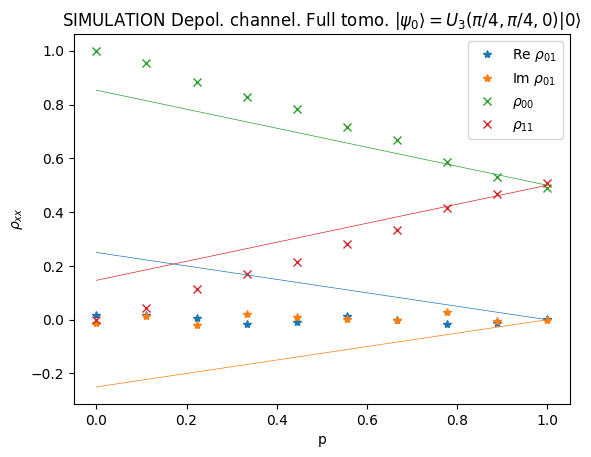

In [6]:
#tomo_rhos = np.zeros((2,2,len(p_values)), dtype=complex)

#for (i, p) in enumerate(p_values):
#    tomo_fitter = StateTomographyFitter(tomography_results[i], tomography_circuits[i])
#    tomo_rhos[:,:,i] = tomo_fitter.fit()
print(tomo_rhos[0][1])
r01 = []
i01 = []
r00 = []
r11 = []

for rho in tomo_rhos:
    r00.append(np.real(rho[0][0]))
    r01.append(np.real(rho[0][1]))
    i01.append(np.imag(rho[0][1]))
    r11.append(np.real(rho[1][1]))

# Simulated results
plt.plot(p_values, r01,"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, i01,"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, r00,"C2x", label='$\\rho_{00}$')
plt.plot(p_values, r11,"C3x", label='$\\rho_{11}$')

# Theoretical prediction

# We obtain the density operator of the initial state
rho0 = partial_trace(DensityMatrix.from_instruction(prepare_state), [0, 1, 3, 4]).data

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");